# Solving the TSP using Self-organizing Map (SOM)

In [1]:
# !pip install MiniSom, tsplib95, requests

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import requests
import tsplib95
import io
from minisom import MiniSom
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load TSP instance

Data is available in Appendix B of the book's GitHub repo and can be read directly using URL begins with raw. The following instances are available in this folder:

| Intsnace     | Country | # of cities | Optimal length |
| --- | --- | --- | --- |
| fi10639.tsp | Finland | 10639 | 520,527 |
| it16862.tsp | Italy | 16,862 | 557,315 |
| qa194.tsp | Qatar | 194 | 9352 |
| uy734.tsp |Uruguay | 734 | 79114 |

More TSP instaces are available at <a href="https://www.math.uwaterloo.ca/tsp/world/countries.html">National Traveling Salesman Problems</a>.

In [3]:
url ="https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/256207c4a8badc0977286c48a6e1cfd33237a51d/Appendix%20B/data/TSP/qa194.tsp"

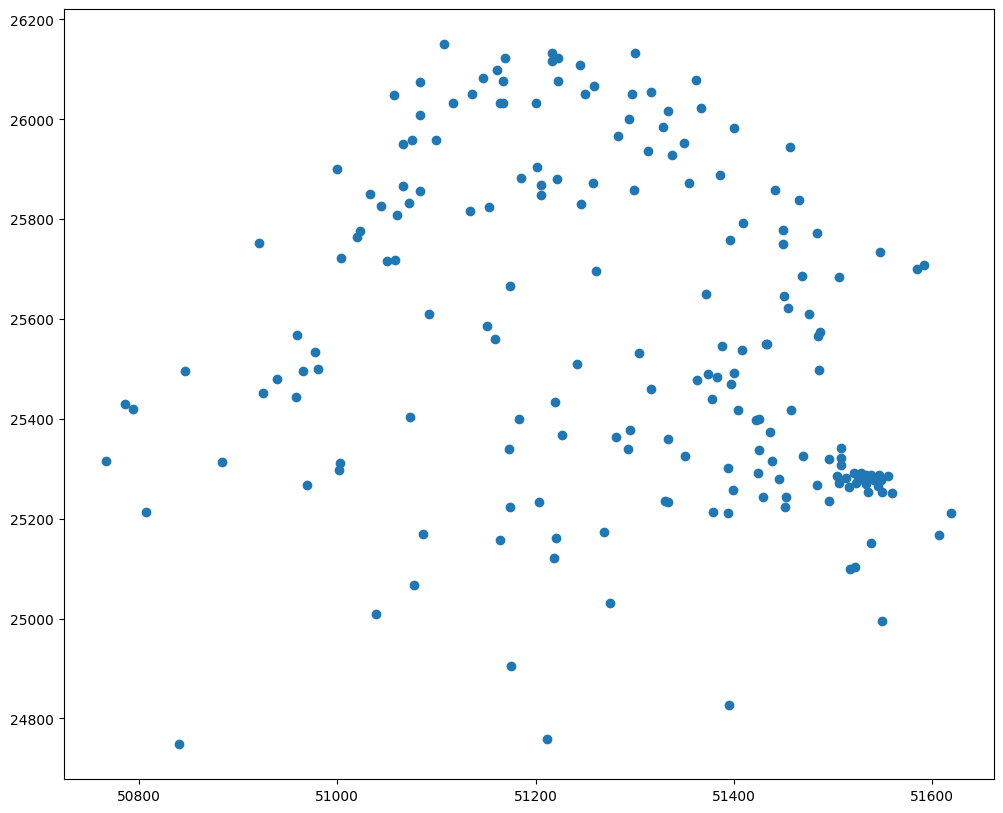

In [4]:
response = requests.get(url)
response.raise_for_status()  # Ensure we got an OK response
problem_text = response.text
problem = tsplib95.parse(problem_text)

cities=problem.node_coords
city_count = len(cities)
# Get the x (longitude) and y (latitude) 2D coordinates for each city
x = [city[1][1] for city in cities.items()]
y = [city[1][0] for city in cities.items()]
points = np.array([x,y]).T
plt.figure(figsize=(12,10))
plt.scatter(x, y)

### Train SOM

In [5]:
N_neurons = city_count

# Create a self-organizing map with 1xN_neurons grid
som = MiniSom(1, N_neurons, 2, sigma=6, learning_rate=.7,
              neighborhood_function='gaussian', random_seed=0)
# Initialize weights
som.random_weights_init(points)
# Train the SOM
som.train(points, 2000, verbose=False, random_order=False)

### Run SOM to solve the TSP and visualize the progress

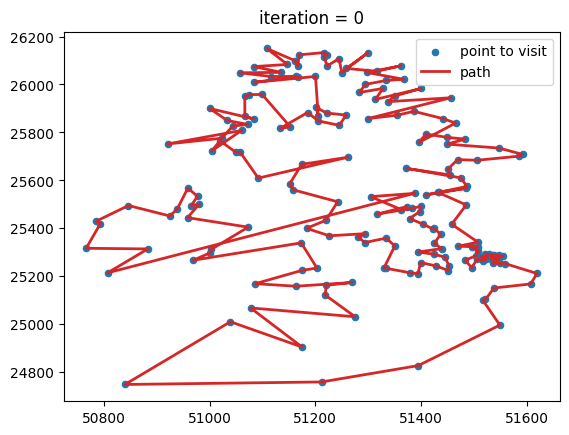

In [10]:
max_iter = 2000

paths_x = []
paths_y = []
for i in np.arange(max_iter):
    i_point = i % len(points)
    som.update(points[i_point], som.winner(points[i_point]), i, max_iter)
    visit_order = np.argsort([som.winner(p)[1] for p in points])
    visit_order = np.concatenate((visit_order, [visit_order[0]]))
    paths_x.append(points[visit_order][:,0])
    paths_y.append(points[visit_order][:,1])

fig, ax = plt.subplots()
plt.scatter(x, y, label='point to visit', s=20)
ln, = plt.plot([], [], 'C3', linewidth=2, label='path')
plt.legend()

def update(frame):
    ln.set_data(paths_x[frame], paths_y[frame])
    plt.title('iteration = %d' % frame)
    if frame == (max_iter - 1):  # check if it is the last frame
        plt.savefig('output.png', dpi=300)  # save the figure
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(max_iter),
                    interval=10, repeat=False, blit=False)
HTML(ani.to_html5_video())